In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

In [2]:
import os
data = {}
a=0
max_len = 0
for j in range(1,7):
    for i in os.listdir('./new_data/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('new_data/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            data['%s'%a]['frameNb']-=data['%s'%a].loc[0,'frameNb']
            if len(data['%s'%a])/20>max_len:
                max_len=int(len(data['%s'%a])/20)
            

In [3]:
a = 0
inputs = np.zeros([10,len(data),5*max_len])
gt = np.zeros([11,len(data),5])
in_coord = np.zeros([10,len(data),2])
gt_coord = np.zeros([11,len(data),2])

for i in data:
    len_d = np.int(len(data['%s'%i])/20)
    for j in range(len_d):
        inputs[:,a,j*5:(j+1)*5] = data['%s'%i].loc[j*10:(j+1)*10-1,['frameNb','x','y','Vx','Vy']]
    
    gt[:,a,:] = np.array(data['%s'%i].loc[9:19,['frameNb','x','y','Vx','Vy']])
    in_coord[:,a,:] = np.array(data['%s'%i].loc[0:9,['x','y']])
    gt_coord[:,a,:] = np.array(data['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs = torch.from_numpy(inputs).float()
gt = torch.from_numpy(gt).float()
inputs = inputs.permute([1,0,2])
gt = gt.permute([1,0,2])



In [4]:
inputs.shape, gt.shape

(torch.Size([4926, 10, 90]), torch.Size([4926, 11, 5]))

In [5]:
from torch import optim

lr = 0.01
lstm = LSTM(5*max_len)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [6]:
traindataset = utils.TensorDataset(inputs, gt[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=2, shuffle=True)

epochs = 50
steps = 0
print_every = 500
running_loss = 0 

for e in range(epochs):
    start = time.time()
    if (e+1)%5==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=0.005)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        #pdb.set_trace()
        out = lstm.forward(in_train)
        #print(out.shape)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]

    
        if steps % print_every == 0:
                stop = time.time()
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every),
                  "{:.8f} lr".format(lr)
                 )
                running_loss = 0
                start = time.time()

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/50.. Loss: 24.6244.. 0.0059 s/batch 0.01000000 lr
Epoch: 1/50.. Loss: 19.6896.. 0.0057 s/batch 0.01000000 lr
Epoch: 1/50.. Loss: 18.6905.. 0.0056 s/batch 0.01000000 lr
Epoch: 1/50.. Loss: 23.1204.. 0.0059 s/batch 0.01000000 lr
Epoch: 2/50.. Loss: 25.0753.. 0.0004 s/batch 0.01000000 lr
Epoch: 2/50.. Loss: 22.6077.. 0.0055 s/batch 0.01000000 lr
Epoch: 2/50.. Loss: 20.6454.. 0.0057 s/batch 0.01000000 lr
Epoch: 2/50.. Loss: 24.1065.. 0.0056 s/batch 0.01000000 lr
Epoch: 2/50.. Loss: 19.6717.. 0.0064 s/batch 0.01000000 lr
Epoch: 3/50.. Loss: 18.6692.. 0.0008 s/batch 0.01000000 lr
Epoch: 3/50.. Loss: 21.6239.. 0.0058 s/batch 0.01000000 lr
Epoch: 3/50.. Loss: 28.0423.. 0.0058 s/batch 0.01000000 lr
Epoch: 3/50.. Loss: 18.6526.. 0.0057 s/batch 0.01000000 lr
Epoch: 3/50.. Loss: 25.0716.. 0.0057 s/batch 0.01000000 lr
Epoch: 4/50.. Loss: 17.6831.. 0.0012 s/batch 0.01000000 lr
Epoch: 4/50.. Loss: 17.1706.. 0.0065 s/batch 0.01000000 lr
Epoch: 4/50.. Loss: 20.6288.. 0.0056 s/batch 0.01000000 

Epoch: 29/50.. Loss: 21.9361.. 0.0057 s/batch 0.00000320 lr
Epoch: 29/50.. Loss: 19.4485.. 0.0057 s/batch 0.00000320 lr
Epoch: 29/50.. Loss: 24.3748.. 0.0056 s/batch 0.00000320 lr
Epoch: 29/50.. Loss: 21.4109.. 0.0057 s/batch 0.00000320 lr
Epoch: 30/50.. Loss: 22.3864.. 0.0008 s/batch 0.00000064 lr
Epoch: 30/50.. Loss: 22.3858.. 0.0057 s/batch 0.00000064 lr
Epoch: 30/50.. Loss: 23.9031.. 0.0058 s/batch 0.00000064 lr
Epoch: 30/50.. Loss: 19.4508.. 0.0057 s/batch 0.00000064 lr
Epoch: 30/50.. Loss: 19.4412.. 0.0057 s/batch 0.00000064 lr
Epoch: 31/50.. Loss: 22.4100.. 0.0012 s/batch 0.00000064 lr
Epoch: 31/50.. Loss: 18.9575.. 0.0057 s/batch 0.00000064 lr
Epoch: 31/50.. Loss: 28.3303.. 0.0057 s/batch 0.00000064 lr
Epoch: 31/50.. Loss: 21.4087.. 0.0057 s/batch 0.00000064 lr
Epoch: 31/50.. Loss: 18.9426.. 0.0058 s/batch 0.00000064 lr
Epoch: 32/50.. Loss: 20.4399.. 0.0015 s/batch 0.00000064 lr
Epoch: 32/50.. Loss: 23.3847.. 0.0056 s/batch 0.00000064 lr
Epoch: 32/50.. Loss: 23.8865.. 0.0057 s/

In [7]:
inputs_pred = inputs.permute([1,0,2])
output_final = lstm.predict(inputs_pred)
output_final = output_final.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [8]:
output_final.shape

(10, 4926, 5)

In [9]:
output_coord=np.zeros([11,len(data),2])
for j in range(11):
    for i in range(len(data)):
        if j==0:
            output_coord[j,i,0:2] = in_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_coord[j-1,i,1:3]+output_final[j-1,i,3:]*0.4
        

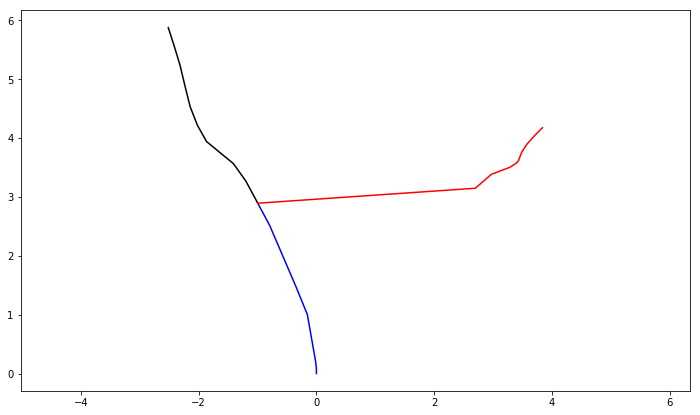

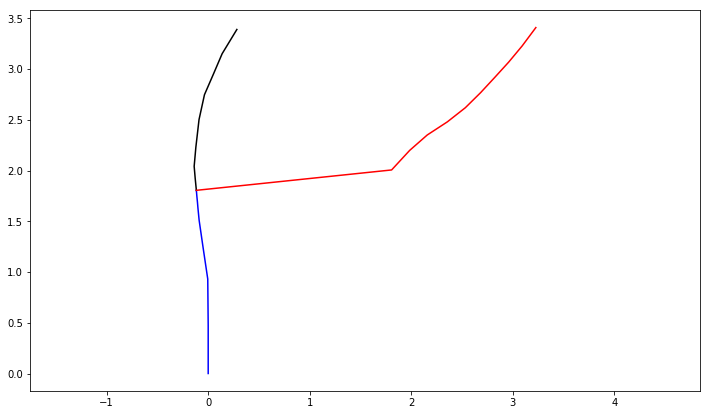

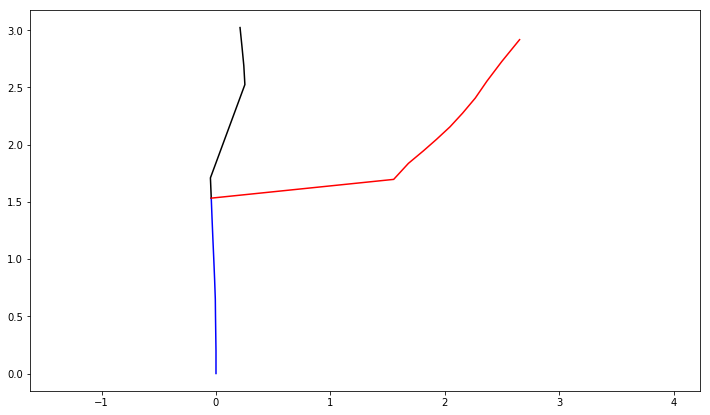

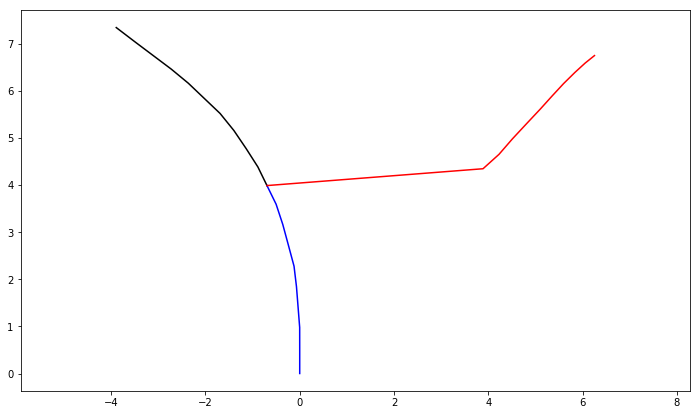

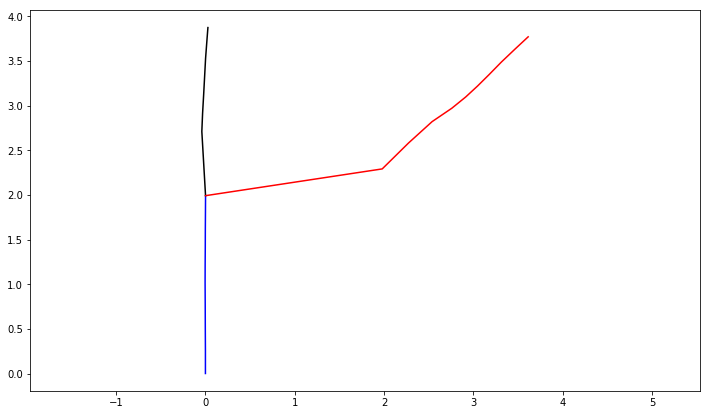

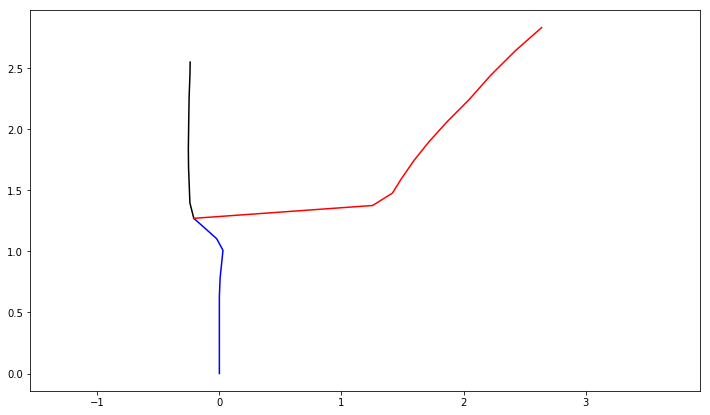

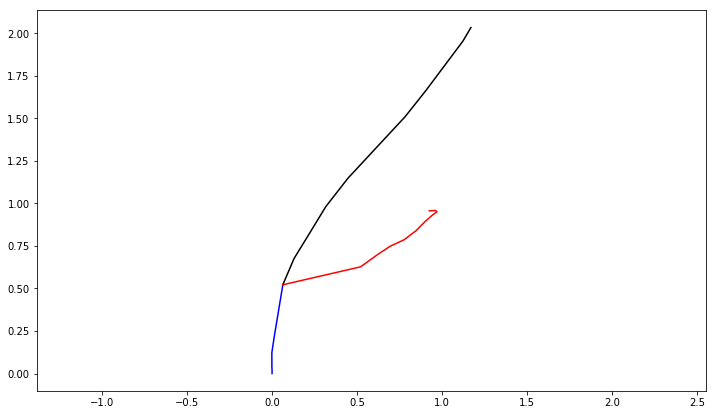

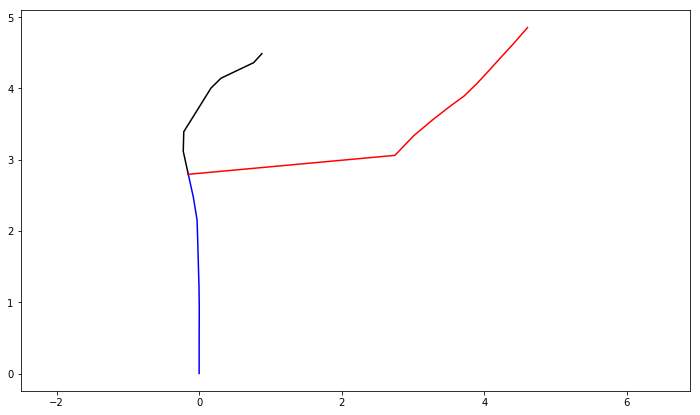

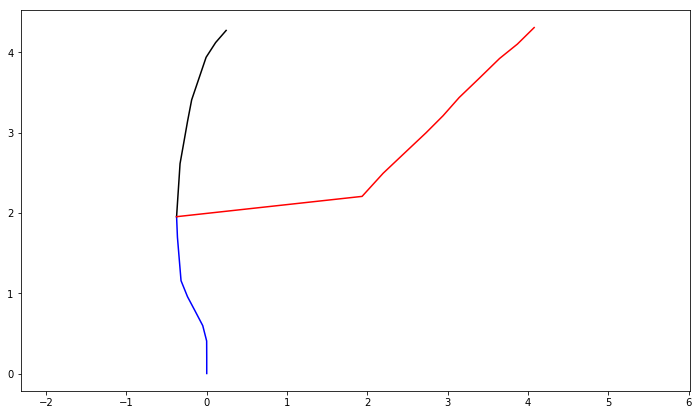

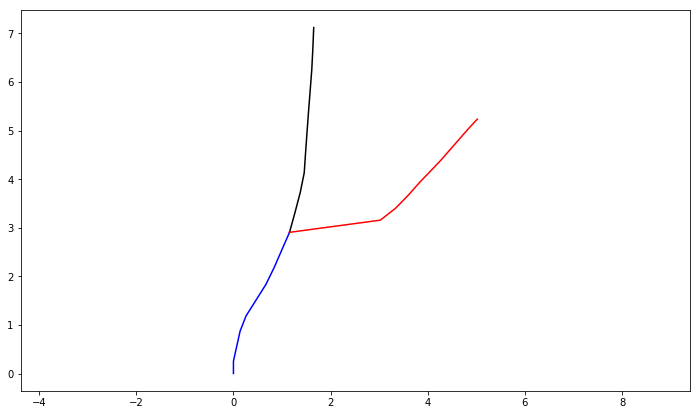

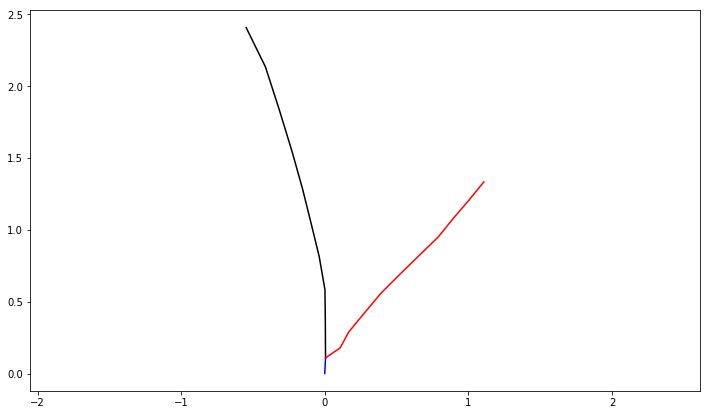

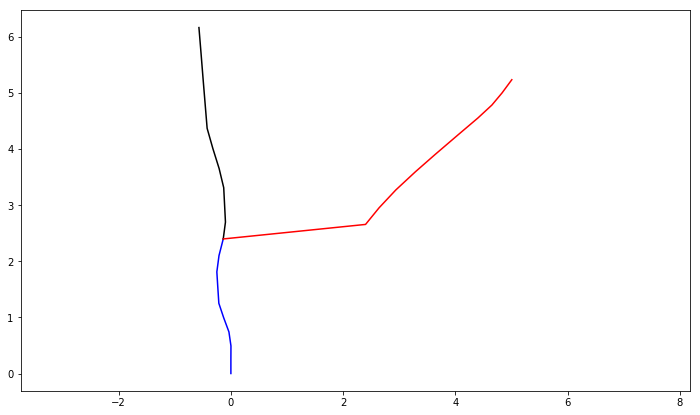

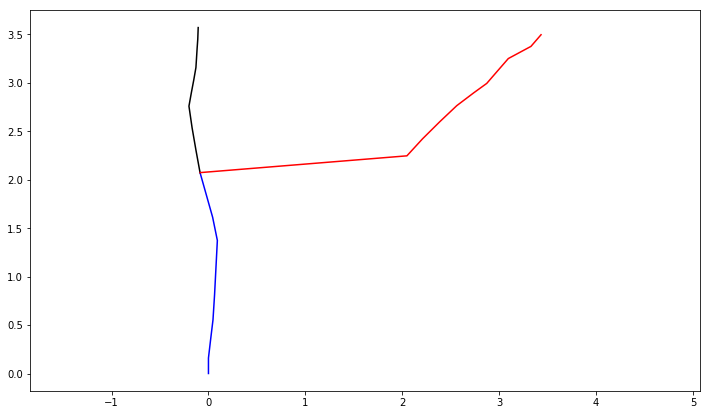

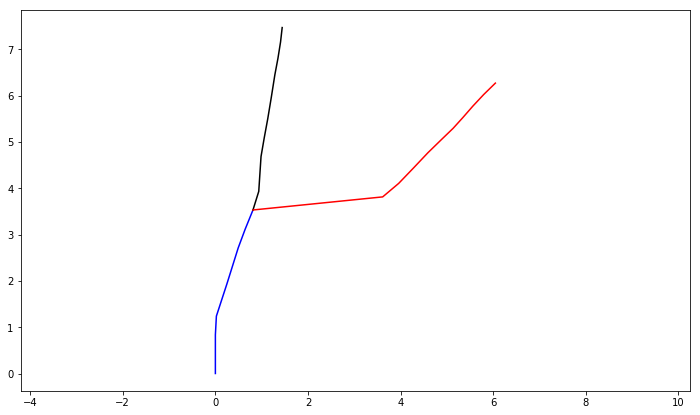

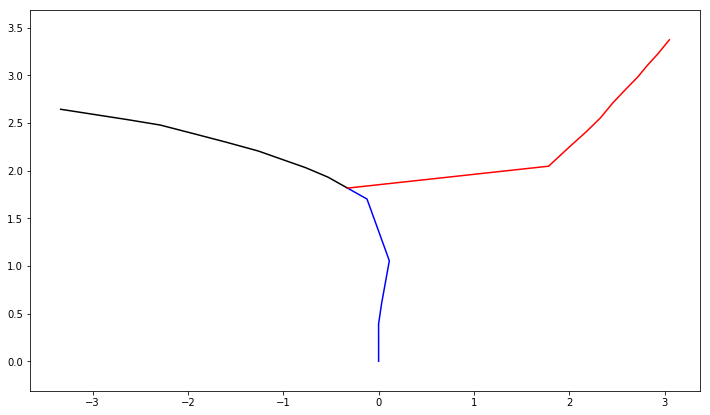

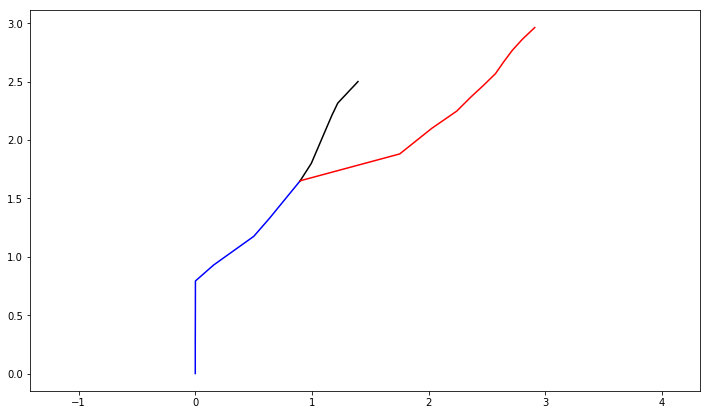

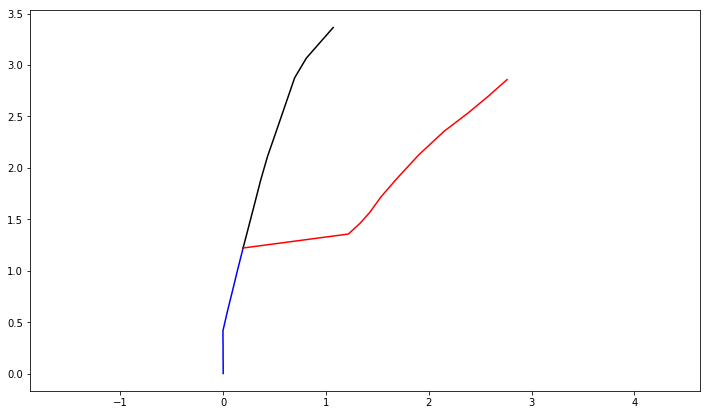

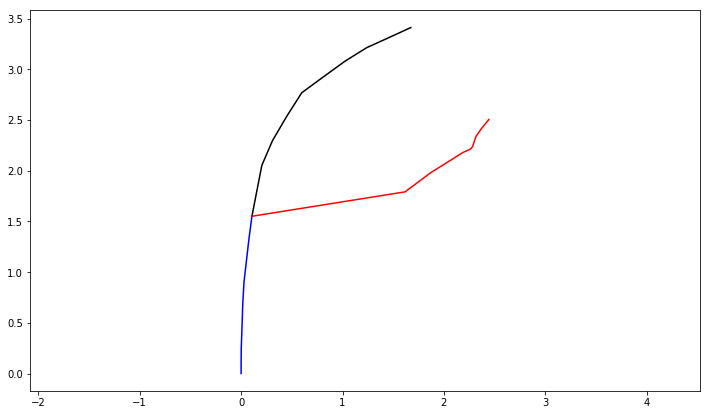

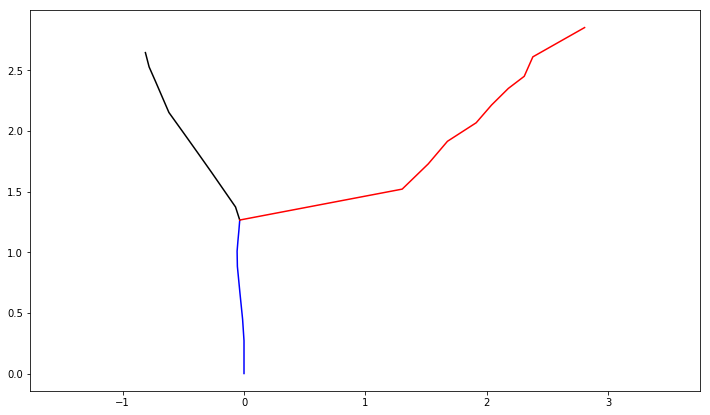

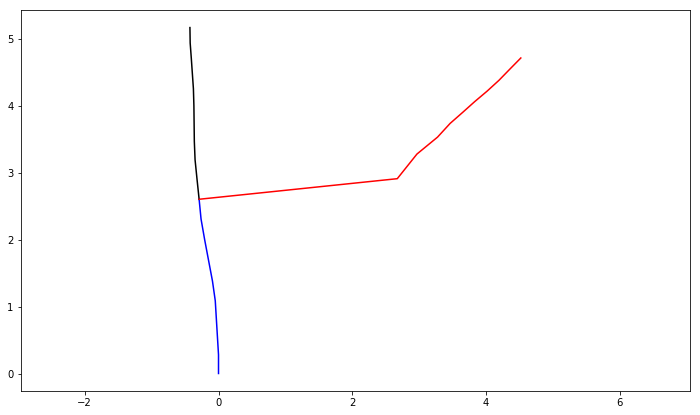

In [10]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[:,(i*20)+4000,0],in_coord[:,i*20+4000,1],c='b')
    plt.plot(gt_coord[:,i*20+4000,0],gt_coord[:,i*20+4000,1],c='k')
    plt.plot(output_coord[:,i*20+4000,0],output_coord[:,i*20+4000,1],c='r')
    plt.axis('equal')

In [ ]:
max_len = np.int(len(data['4000'])/20)
test = np.zeros([10,1,5*max_len])

In [ ]:
for i in range(max_len):
    test[:,0,i*4:(i+1)*4] = np.array(data['4000'].loc[i*10:(i+1)*10-1,'x':'Vy'])


In [ ]:
output_coord[1:,0,:]-output_final[:,0,0:2]

In [ ]:
dist = []
for i in range(len(data)):
    dist.append(sum(np.sqrt((output_coord[0,i,:]-output_coord[-1,i,:])**2)))

In [ ]:
np.std(dist),np.mean(dist)

In [ ]:
a = data['400']
infe = a.loc[0,'frameNb']
sup = a.loc[19,'frameNb']
a = a[a['frameNb']>=infe]
a = a[a['frameNb']<=sup]
a.index = range(len(a))

In [ ]:
a

In [ ]:
data['1']

In [ ]:
output_final

In [ ]:
gt[0,:,:]

In [ ]:
data['1']

In [ ]:
np.array(data['%s'%1].loc[9:19,['frameNb','x','y','Vx','Vy']]).shape

In [ ]:
inputs.shape

In [ ]:
inputs[4000,-1,3:5]

In [ ]:
output_final[0,4000,3:]